# Analyse données Vélos partagées

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

On importe les données correspondant au réseau de vélos partagés lyonnais, et on considère cinq semaines de mesures, soit entre le lundi 21 août 2017 et le dimanche 25 septembre 2017.

In [2]:
lyon = pd.read_csv("./data/lyon.csv", parse_dates = ['last_update'])
lyon = lyon.query("last_update >= '2017-08-21' and last_update < '2017-09-25'")

In [3]:
print(lyon.shape)
lyon.head(10)

(3494564, 9)


,number,last_update,bike_stands,available_bike_stands,available_bikes,availabilitycode,availability,bonus,status
3867410,10063,2017-08-21 00:03:21,34,22,12,1,Vert,Non,OPEN
3867417,8015,2017-08-21 00:01:07,16,4,12,1,Vert,Non,OPEN
3867418,7057,2017-08-21 00:00:52,24,0,23,2,Bleu,Non,OPEN
3867419,7007,2017-08-21 00:02:30,20,2,18,1,Vert,Non,OPEN
3867421,1003,2017-08-21 00:02:52,16,14,1,1,Vert,Non,OPEN
3867423,7056,2017-08-21 00:03:30,22,0,22,2,Bleu,Non,OPEN
3867427,10031,2017-08-21 00:00:00,22,4,17,1,Vert,Non,OPEN
3867428,1016,2017-08-21 00:02:58,17,15,2,1,Vert,Non,OPEN
3867430,10120,2017-08-21 00:00:50,16,0,15,2,Bleu,Non,OPEN
3867432,10122,2017-08-21 00:00:59,21,18,3,1,Vert,Non,OPEN


Pour se représenter l'activité d'une station Velov, on affiche une simple chronique temporelle du nombre de vélo disponible sur la station, ainsi que du nombre de stations disponibles. En principe, ces deux grandeurs donnent le nombre d'emplacements total sur la station, mais il peut arriver qu'un ou plusieurs emplacements soient en maintenance ; on conserve tout de même l'idée que le nombre total d'emplacement est une borne supérieure de la somme des vélos et des emplacements disponibles.

In [4]:
def plot_station(data, index):
    """Plot available bikes and bike stands for a given station"""
    station = data.query("number == @index")
    f, ax = plt.subplots(2, 1, figsize=(16, 6))
    ax[0].plot(station.last_update, station.available_bike_stands, 'r-')
    ax[0].set_xlabel("Available bike stands")
    ax[1].plot(station.last_update, station.available_bikes, 'b-')
    ax[1].set_xlabel("Available bikes")

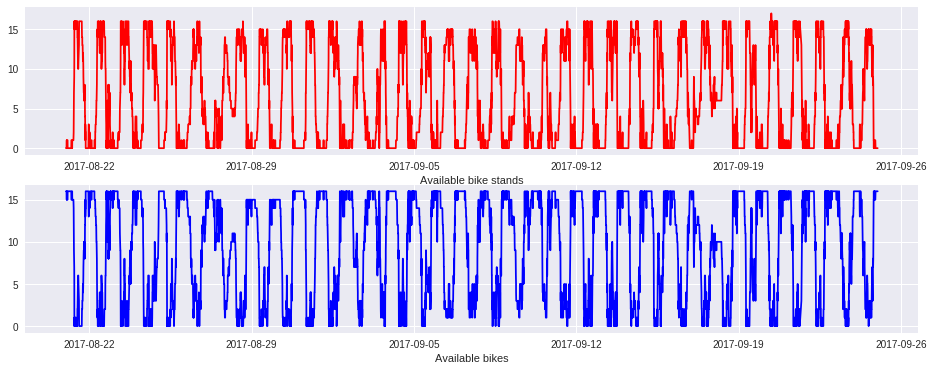

In [5]:
plot_station(lyon, 3085)

Pour la prochaine section (analyse de séries temporelles), on ne considère qu'une station Velov, mais la même analyse peut être réalisée pour n'importe quelle station.

In [6]:
station = lyon.query("number == 3085")
avl_velos = station.set_index("last_update")[['available_bikes', 'bike_stands']].resample("15T")
avl_stands = station.set_index("last_update")[['available_bike_stands', 'bike_stands']].resample("15T")

## Analyse de série temporelle avec Pyflux

Une première tentative d'analyse des séries temporelles est réalisée avec le package `pyflux`, solution standard dans cette optique.

In [7]:
import pyflux as pf

In [8]:
model = pf.ARIMA(avl_velos.reset_index(), 4, 4)

In [9]:
x = model.fit()
x.summary()

Hessian not invertible! Consider a different model specification.

Normal ARIMA(4,0,4)                                                                                       
======================================================= ==================================================
Dependent Variable: last_update                         Method: MLE                                       
Start Date: 4                                           Log Likelihood: -1.02642917433e+31                
End Date: 3359                                          AIC: 2.05285834867e+31                            
Number of observations: 3356                            BIC: 2.05285834867e+31                            
Latent Variable                          Estimate  
======================================== ==========
Constant                                 1.50478515
AR(1)                                    -0.0      
AR(2)                                    -0.0      
AR(3)                          

On obtient ce résultat, donnant la valeur des coefficients propres au modèle _ARIMA_. Trouver un jeu de paramètres pour lequel la matrice Hessienne est inversible reste toutefois compliqué, et dans ce cas de figure, il est impossible de confronter les valeurs obtenues à des tests statistiques.

On observe également que les coefficients associés à la partie auto-regressive du modèle sont nuls.

## Analyse de série temporelle avec Fbprophet

Pour aller plus loin, une autre librairie Python existe : [Prophet](https://facebook.github.io/prophet/), dont le code est disponible sur [Github](https://github.com/facebook/prophet).

In [10]:
from fbprophet import Prophet

In [11]:
avl_velos = avl_velos.reset_index()

Inconvénient, il faut absolument que la colonne correspondant aux dates soit nommée `ds`, et que celle référant aux données mesurées soit nommée `y`. Une borne supérieure correspondant à la capacité du phénomène étudiée peut être rajoutée, la colonne correspondante devant être nommée `cap`. Ici, nous sommes dans ce cas, puisque la quantité de vélos disponible par station est bornée par le nombre d'emplacements.

In [12]:
avl_velos.columns = ["ds", "y", "cap"]
data = avl_velos.query("ds < '2017-09-18'")
future = avl_velos.query("ds >= '2017-09-18'")

Un modèle est déclaré selon un mode de croissance `linear` ou `logistic`, les différentes composantes de saisonnalité peuvent être précisées également (sans compter que des éléments de saisonnalité supplémentaires peuvent être rajoutés par la suite, _cf_ API).

In [13]:
m = Prophet(growth='logistic',
            daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False,
            n_changepoints=10)
m.fit(data)
forecast = m.predict(future)

In [14]:
forecast.sample().T

,311
ds,2017-09-21 05:45:00
trend,9.12176
cap,16
trend_lower,9.08707
trend_upper,9.16213
yhat_lower,9.84496
yhat_upper,17.758
daily,5.25171
daily_lower,5.25171
daily_upper,5.25171


`Prophet` dispose d'une fonction d'affichage très propre, que l'on peut hacker via l'API de `matplotlib` (exemple ici : on rajoute les points correspondants aux observations réelles, en vert, à comparer aux prévisions du modèle, en bleu).

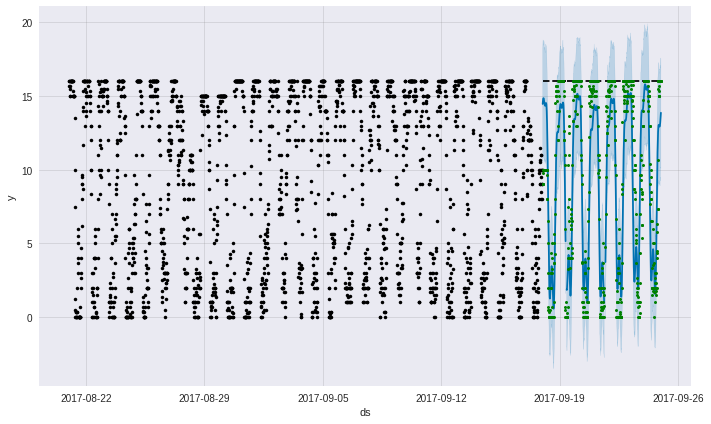

In [15]:
mp = m.plot(forecast)
test = mp.get_axes()
test[0].plot(future.ds, future.y, 'go', ms=3)

Une autre fonction bien pratique permet d'afficher les composantes de la prévision, en séparant la courbe tendancielle des effets de saisonnalité.

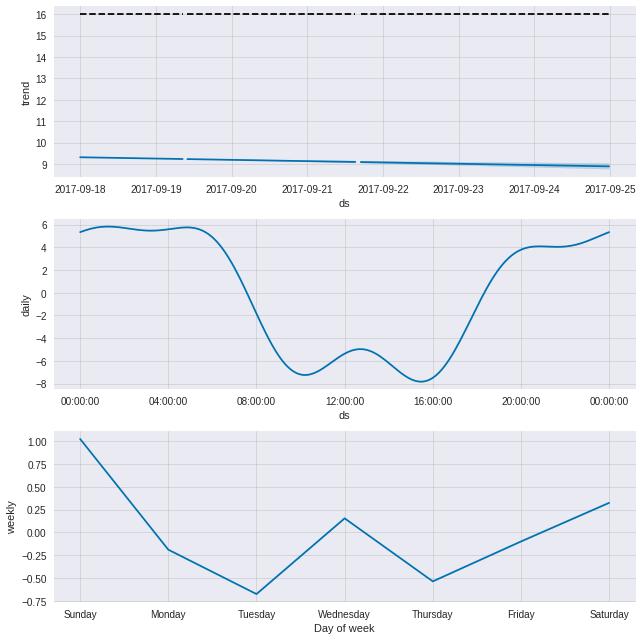

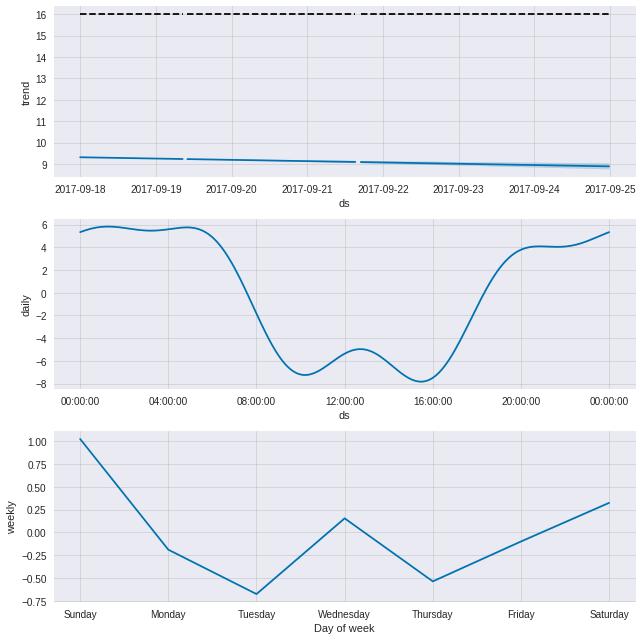

In [16]:
m.plot_components(forecast)

Malheureusement (au-delà du petit bug qui fait afficher les courbes en double), aucune fonction ne permet de récupérer les données ayant conduit à la génération de ces graphiques... Celle-ci peuvent malgré tout être reconstruites à la main, ce que nous pouvons montrer dans la section suivante.

## Récupération des données de saisonnalité

Deux effets de saisonnalité sont cruciaux ici : l'effet de heure de la journée, et celui du jour de la semaine.

### Saisonnalité par rapport au jour de la semaine

In [17]:
days_of_week = ["lundi", "mardi", "mercredi", "jeudi", "vendredi", "samedi", "dimanche"]
forecast['day_index'] = forecast['ds'].dt.dayofweek
forecast['day'] = [days_of_week[index] for index in forecast['day_index']]

In [18]:
forecast.groupby("day")['weekly'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
dimanche,96.0,0.607638,0.379483,-0.169959,0.300822,0.708380,0.961072,1.025718
jeudi,96.0,-0.397827,0.146986,-0.555039,-0.539241,-0.438583,-0.273847,-0.106023
lundi,96.0,-0.698012,0.196230,-0.882343,-0.853698,-0.771492,-0.598803,-0.189396
mardi,96.0,-0.141091,0.274846,-0.675397,-0.374509,-0.073740,0.122290,0.163924
mercredi,96.0,-0.187654,0.227663,-0.533448,-0.401420,-0.188034,0.027276,0.153986
samedi,96.0,0.700688,0.225651,0.323599,0.496838,0.712092,0.913411,1.021871
vendredi,96.0,0.116258,0.112179,-0.099588,0.030418,0.121469,0.203485,0.317606


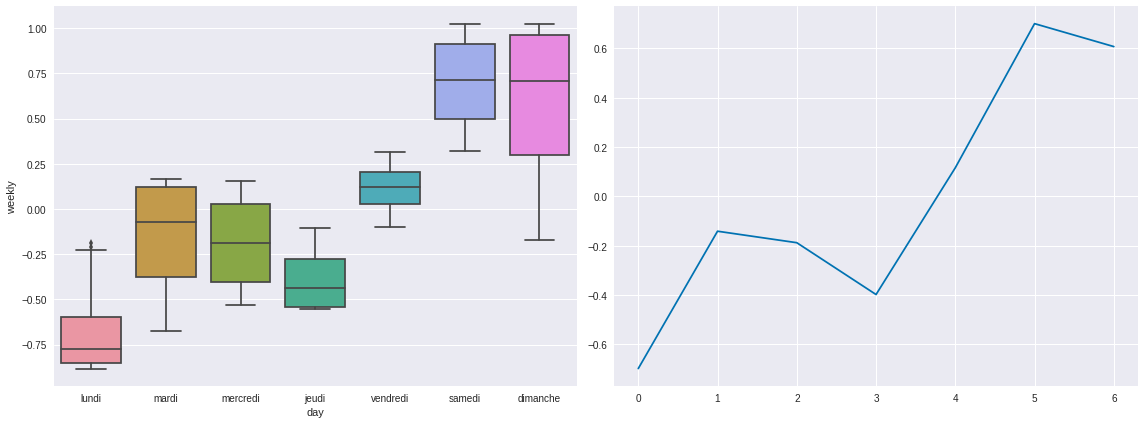

In [19]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x=forecast.day, y=forecast.weekly, ax=ax[0])
ax[1].plot(forecast.day_index.drop_duplicates(), forecast.groupby("day_index")["weekly"].mean(), '-', color='#0072B2')
f.tight_layout()

Le résultat sur les jours de semaine montre une utilisation plus intensive des Velov en semaine, et plus particulièrement le lundi. On note toutefois que ce résultat n'est pas équivalent à celui proposé via l'utilisation des fonctions d'affichage du package `Prophet` (alors même que le calcul à la main utilise la prédiction réalisée via `Prophet`)...

### Saisonnalité due à l'heure de la journée

In [20]:
forecast['hour'] = forecast['ds'].dt.hour

In [21]:
forecast.groupby("hour")['daily'].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,28.0,5.557163,0.156896,5.334756,5.462519,5.574481,5.669125,5.744934
1,28.0,5.803139,0.021724,5.768614,5.796339,5.808713,5.815513,5.826517
2,28.0,5.604372,0.074918,5.510010,5.552229,5.600674,5.652817,5.706130
3,28.0,5.486795,0.023690,5.464673,5.471942,5.478472,5.493326,5.525565
4,28.0,5.677153,0.063621,5.586751,5.637985,5.685393,5.724560,5.751072
5,28.0,5.542688,0.191155,5.251708,5.445277,5.588688,5.686099,5.741667
6,28.0,4.019292,0.702510,3.036919,3.588210,4.079925,4.511006,4.880397
7,28.0,0.730108,1.132895,-0.787925,-0.005031,0.757421,1.492560,2.193515
8,28.0,-3.327277,1.102696,-4.742879,-4.073755,-3.362159,-2.615681,-1.841910


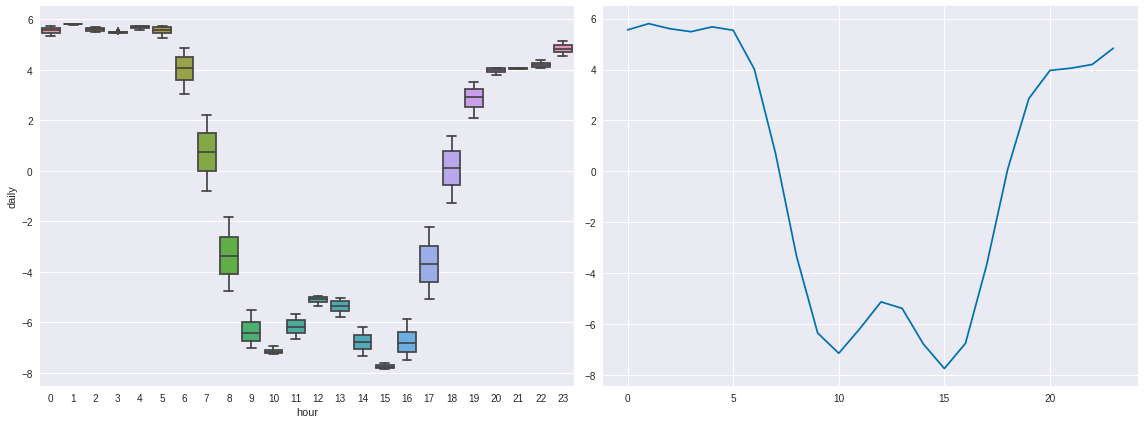

In [22]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(x=forecast.hour, y=forecast.daily, ax=ax[0])
ax[1].plot(forecast.hour.drop_duplicates(), forecast.groupby("hour")["daily"].mean(), '-', color='#0072B2')
f.tight_layout()


Le résultat en fonction des heures est aussi extrêmement intéressant : les Velov sont très utilisés en journée, et particulièrement sur des pointes matinales à 10h le matin et 15h l'après-midi. La nuit, la station tend généralement à être remplie. Au contraire des jours de la semaine, ce résultat correspond à celui proposé par le package `Prophet`.

## Generaliser à l'ensemble des stations Velov

On cherche à reproduire le travail précédent sur l'ensemble des stations pour caractériser chacune avec des profils temporels.

In [23]:
station_ids = lyon.number.drop_duplicates()

In [24]:
def daily_pattern(data, station):
    avl_velos = data.query("number==@station").set_index("last_update")['available_bikes'].resample("15T").reset_index()
    avl_velos['hour'] = avl_velos['last_update'].dt.hour
    daily_pattern = avl_velos.groupby("hour")["available_bikes"].mean()
    return daily_pattern

In [25]:
def weekly_pattern(data, station):
    avl_velos = data.query("number==@station").set_index("last_update")['available_bikes'].resample("15T").reset_index()
    avl_velos['day'] = avl_velos['last_update'].dt.dayofweek
    weekly_pattern = avl_velos.groupby("day")["available_bikes"].mean()
    return weekly_pattern

In [ ]:
daily_patterns = pd.DataFrame([daily_pattern(lyon, station_id) for station_id in station_ids])
daily_patterns.index = station_ids
weekly_patterns = pd.DataFrame([weekly_pattern(lyon, station_id) for station_id in station_ids])
weekly_patterns.index = station_ids

## Clustering sur les stations Velov, par rapport à la disponibilité des vélos

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
model = KMeans(n_clusters=4, random_state=0)

In [ ]:
result = model.fit(weekly_patterns)

In [ ]:
weekly_pattern_labels = pd.DataFrame({"label": result.labels_}, index=weekly_patterns.index)

### Afficher les stations sur une carte d'après leur cluster d'appartenance

In [ ]:
import folium

In [ ]:
position = [45.750000, 4.850000] # Lyon lat, lon coordinates

In [ ]:
mp = folium.Map(location=position, zoom_start=13, tiles='cartodbpositron')

In [ ]:
locations = pd.read_csv("./data/lyon-stations.csv")

In [ ]:
locations = locations.merge(weekly_pattern_labels, right_index=True, left_on='idstation')

In [ ]:
locations.query("idstation==3085")

In [ ]:
colors = sns.color_palette('Set1', 4)
hex_colors = colors.as_hex()

In [ ]:
locations["color"] = [hex_colors[label] for label in locations.label]
for _, row in locations.iterrows():
    plt.plot(row.lon, row.lat, 'o', color=row.color)

In [ ]:
for _,row in locations.iterrows():
    folium.CircleMarker(
        location=[row['lon'], row['lat']],
        radius=5,
        popup=row['nom'],
        color=hex_colors[row['label']],
        fill=True,
        fill_opacity=0.7,
        fill_color=hex_colors[row['label']]
    ).add_to(mp)

In [ ]:
mp